In [1]:
from umap import UMAP
import hdbscan
from hdbscan import HDBSCAN
from pymethylprocess.MethylationDataTypes import MethylationArray
from pymethylprocess.general_machine_learning import MachineLearning
model=MachineLearning(RandomForestRegressor,options={})
import pandas as pd, numpy as np
from sklearn.decomposition import PCA
import matplotlib, matplotlib.pyplot as plt
import seaborn as sns
from seaborn import cubehelix_palette
# sns.set()

## Load Data

In [2]:
train_methyl_array=MethylationArray.from_pickle("train_val_test_sets/train_methyl_array.pkl")
val_methyl_array=MethylationArray.from_pickle("train_val_test_sets/val_methyl_array.pkl")
test_methyl_array=MethylationArray.from_pickle("train_val_test_sets/test_methyl_array.pkl")

In [13]:
print((train_methyl_array.pheno.columns))
# print((train_methyl_array.beta.T.columns.values))

Index(['X', 'Basename', 'AccNum', 'disease', 'Age', 'Sex', 'Tissue', 'Gran',
       'CD4T', 'CD8T', 'Bcell', 'Mono', 'NK', 'gMDSC', 'filenames', 'Cluster'],
      dtype='object')


## UMAP Embed

In [4]:
umap = UMAP(n_components=100)
umap.fit(train_methyl_array.beta)
train_methyl_array.beta = pd.DataFrame(umap.transform(train_methyl_array.beta.values),index=train_methyl_array.return_idx())
val_methyl_array.beta = pd.DataFrame(umap.transform(val_methyl_array.beta),index=val_methyl_array.return_idx())
test_methyl_array.beta = pd.DataFrame(umap.transform(test_methyl_array.beta),index=test_methyl_array.return_idx())

## Cluster Training Data

In [5]:
def reduce_plot(data, labels, legend_title):
    np.random.seed(42)
    plt.figure(figsize=(8,8))
    t_data=pd.DataFrame(PCA(n_components=2).fit_transform(data),columns=['z1','z2'])
    t_data[legend_title]=labels
    sns.scatterplot('z1','z2',hue=legend_title, cmap=cubehelix_palette(as_cmap=True),data=t_data)


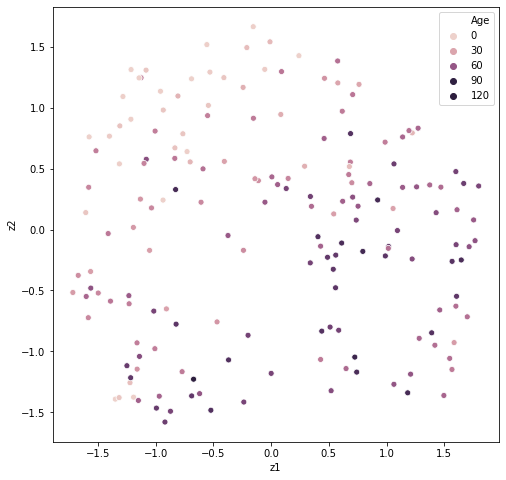

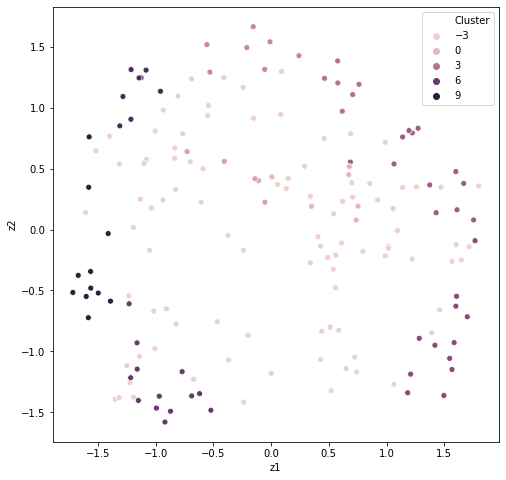

In [6]:
model = HDBSCAN(algorithm='best')
train_predicted_clusters = model.fit_predict(train_methyl_array.beta.astype(np.float64))
reduce_plot(train_methyl_array.beta, train_methyl_array.pheno['Age'].values,'Age')
reduce_plot(train_methyl_array.beta, train_predicted_clusters,'Cluster')

In [7]:
import tabulate
train_methyl_array.pheno['Cluster']=train_predicted_clusters
output_data=train_methyl_array.pheno.groupby('Cluster')['Age'].agg([np.mean,len])
print(tabulate.tabulate(output_data,headers='keys',tablefmt="pipe"))

|   Cluster |    mean |   len |
|----------:|--------:|------:|
|        -1 | 52.6146 |    96 |
|         0 | 49.5    |     6 |
|         1 | 35.6    |     5 |
|         2 | 18      |     7 |
|         3 | 39.3333 |     6 |
|         4 | 55.5833 |    12 |
|         5 | 55.5    |    12 |
|         6 | 60.5385 |    13 |
|         7 | 20.125  |     8 |
|         8 | 40.6364 |    11 |


## Supervised Model

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

y_pred = {}
scores={}
model=MachineLearning(RandomForestRegressor,options={})
model.fit(train_methyl_array,val_methyl_array,'Age')
y_pred['train']=model.predict(train_methyl_array)
y_pred['val']=model.predict(val_methyl_array)
y_pred['test']=model.predict(test_methyl_array)

scores['train']=r2_score(train_methyl_array.pheno['Age'],y_pred['train'])
scores['val']=r2_score(val_methyl_array.pheno['Age'],y_pred['val'])
scores['test']=r2_score(test_methyl_array.pheno['Age'],y_pred['test'])
scores

{'train': 0.9433408959632967,
 'val': 0.6270127805864034,
 'test': 0.6233903055326178}

In [9]:
from sklearn.metrics import max_error
max_errors = {}
max_errors['train'] = max_error(train_methyl_array.pheno['Age'], y_pred['train'])
max_errors['val'] = max_error(val_methyl_array.pheno['Age'], y_pred['val'])
max_errors['test'] = max_error(test_methyl_array.pheno['Age'], y_pred['test'])

max_errors

{'train': 15.549999999999997, 'val': 33.19, 'test': 27.68}